# Testing only Unsupervised Methods #
Author: Ayam Babu, with supervision from Tristan Kleyn and Professor Vincent Janik
Experiment recommendation by: Joel Beckles

Date: 20 February, 2024

Purpose of Experiment: Joel Beckles, a teammate of the programmer, recommended the programmer to test whether dimensionality reduction algorithms (embedding higher dimensional data to lower dimensions) make a difference when paired with clustering algorithms. If solely using clustering algorithms have a similar performance, it may not be necessary to have a dimensionality reduction algorithm. Testing the usage of dimensionality reduction algorithms allows the programmer to justify their usefulness through empirical results.

Purpose of Project: Student project as part of the Dolphin Acoustics Vertically Integrated Project (VIP) that classifies dolphin signature whistles. Signature whistles are used to uniquely identify individuals dolphins, and they can be useful for extrapolating the population of groups of dolphins. This project focuses on applying machine learning with Python, specifically unsupervised learning methods that do not require extensive datasets to train, to classifying dolphin whistles. The author uses the labelled Sarasota dataset from dolphins in Sarasota, Florida – where each signature whistle recorded is traceable to a known individual dolphin – to assess the effectiveness of the unsupervised learning methods.

The programmer has given it their best to document their program, but if a future team member has any further questions, they shouldn't hesitate to contact Ayam Babu at ab550@st-andrews.ac.uk.

## Table of Contents: ##
Note: if you have read the 2023-24 Semester 1 notebook, you can skip section 1
1. [Sarasota Dataset Exploration](#Sarasota-Dataset-Exploration)
2. [Deciding which models to use](#Deciding-which-models-to-use)
3. [Experiments](#Experiments)
4. [Analysis & Results](#Analysis-&-Results), final results table: [Top 5 method performances](#Top-5-method-performances)
5. [Conclusion & Future Work](#Conclusion-&-Future-Work)

## Sarasota Dataset Exploration ##

The code below is for finding, then using the dataset. The programmer explored the whistle data closer, so that he could understand the dataset he was working with.

Each cell with "In [#]:" written after it is a snippet of code that is executed individually. Some of these cells have "#" written on the first line: this is an indication that the words following the "#" on the line are comments by the programmer.

In [1]:
from os import listdir

sarasota_dir_path = "../Full dataset"
sarasota_whistle_paths = listdir(sarasota_dir_path)
print(str(len(sarasota_whistle_paths)) + " whistles in the dataset")

1800 whistles in the dataset


In [2]:
# Gather individual names and signature whistles from the Sarasota dataset and store them in separate lists
import pandas as pd

individual_names = []
signature_whistles = []

for sarasota_whistle_path in sarasota_whistle_paths:
    individual_name = sarasota_whistle_path.split("-")[0]
    individual_names.append(individual_name)
    #print(sarasota_dir_path + "/" + sarasota_whistle_path)
    signature_whistle = pd.read_csv(sarasota_dir_path + "/" + sarasota_whistle_path)
    signature_whistles.append(signature_whistle)

In [3]:
# Collect the first whistle as a sample
sarasota_whistle_path_sample = sarasota_whistle_paths[0]
individual_name = sarasota_whistle_path_sample.split("-")[0]
sample_whistle = pd.read_csv(sarasota_dir_path + "/" + sarasota_whistle_path_sample)

In [4]:
# Explore a sample whistle from the dataset
# Each row represents a hydrophone (microphone in water) reading at a given time in ms
# All the readings come together to form the whistle
# For readability, the first 5 readings are shown below

sample_whistle.head()

,Time [ms],Peak Frequency [Hz],Duty Cycle,Energy,WindowRMS
0,1685963745222,8109.3750,1.352765,0.000048,0.022901
1,1685963745227,7945.3125,1.355840,0.000083,0.025138
2,1685963745233,7757.8125,1.424948,0.000066,0.027375
3,1685963745237,7593.7500,1.410701,0.000070,0.027522
4,1685963745242,7406.2500,1.420021,0.000077,0.027827


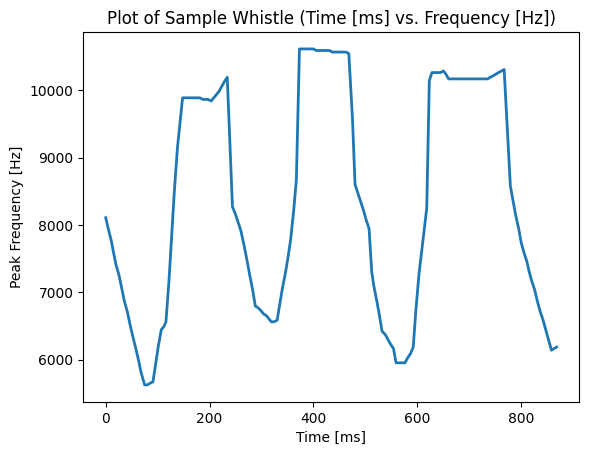

In [5]:
# Plot the first whistle / sample whistle

import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(sample_whistle["Time [ms]"] - sample_whistle["Time [ms]"][0], 
        sample_whistle[" Peak Frequency [Hz]"], linewidth = 2.0)

plt.xlabel("Time [ms]")
plt.ylabel("Peak Frequency [Hz]")
plt.title("Plot of Sample Whistle (Time [ms] vs. Frequency [Hz])")

plt.show()

I was curious about the number of readings per whistle, so I decided to plot the distribution of it. This will help me check if all the whistles have the same number of readings or not, and if not, how many whistles are there for each readings range (e.g. there are almost 300 whistles with the number of readings being 0-50, shown below).

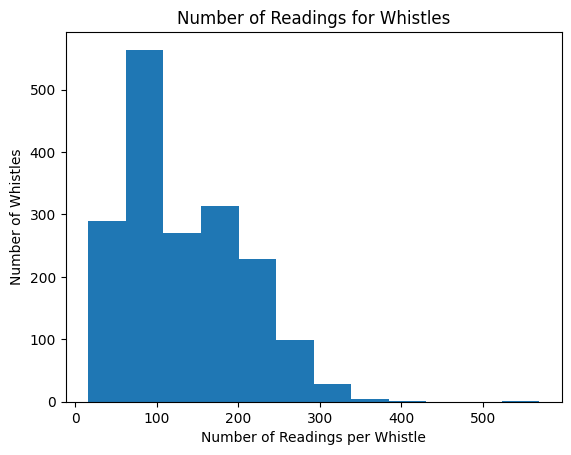

In [6]:
import numpy as np
import matplotlib.pyplot as plt

signature_lengths = [len(signature_whistle) for signature_whistle in signature_whistles]
plt.hist(signature_lengths, bins = 12)

plt.xlabel("Number of Readings per Whistle")
plt.ylabel("Number of Whistles")
plt.title("Number of Readings for Whistles")

plt.show()

## Deciding which models to use ##

A clustering algorithm tries to cluster whistles that are similar together, based on how far the whistle's embeddings are from each other. For the purposes of our problem, all whistles enclosed in each cluster represent whistles attributed to the same individual dolphin.

The programmer has provided a list below of all the clustering algorithms that he has tried out.

Clustering:
* Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
* Hierarchial DBSCAN (HDBSCAN)
* Gaussian Mixture (GM)

Initially, the programmer also experimented with Kernel Density Estimation (KDE) as a clustering algorithm, but due to time constraints, the programmer has decided to not evaluate it. Above is not an exhaustive list of clustering algorithms and more could certainly be added when found.

The produced whistle clusters from each combination have been compared to the dataset's whistle clusters and evaluated through the **Normalized Mutual Information** score. The Normalized Mutual Information score (or NMI) measures the amount of information shared between two sets of clusters on a scale from 0.0 (indicating extreme dissimilarity) to 1.0 (indicating extreme similarity). The **Adjusted Rand Index** score (or ARI) is also tracked, but it is used as a secondary measurement and is not recorded because it makes data more difficult to organize. The Adjusted Rand Index measures the agreement between the items of two sets of clusters.


## Experiments ##
Multiple experiments were conducted, with each clustering algorithm trialled. The clustering algorithms each have parameters (settings) picked randomly or intentionally, which adjust the behaviour. The Normalized Mutual Information score (amount of information shared between two clusters, on a scale of 0.0 to 1.0) for each algorithm combination are recorded in separate spreadsheets, with each spreadsheet containing the results for different algorithm settings. The NMI Score will be calculated through the Scikit-learn library, as it has plenty of built-in metrics.

If the reader has reviewed the 2023-24 Semester 1 notebook, they can skip section 0.

Experiments conducted:

0. [Preprocessing](#Preprocessing)
1. [DBSCAN](#DBSCAN)
2. [GM](#GM)
3. [HDBSCAN](#HDBSCAN)

### Preprocessing ###

Before the whistles can be passed into the models, they need to be processed.

After exploring the dataset, the programmer decided to standardize the whistle lengths to 400 readings. This is simply because a lot of unsupervised machine learning methods that the programmer is planning on using requires fixed size inputs. The dolphin identifier is also matched to a number, as it simplifies some of the programming later on.

In [7]:
# Standardize whistle length to size 400

whistles = []

for signature_whistle in signature_whistles:
    size = len(signature_whistle)
    newsize = 400

    xloc = np.arange(size)
    new_xloc = np.linspace(0, size, newsize)
    new_sw = np.interp(new_xloc, xloc, signature_whistle[" Peak Frequency [Hz]"])
    
    whistles.append(new_sw)
    
print(np.shape(whistles))
print(np.shape(individual_names))

(1800, 400)
(1800,)


In [8]:
# Dolphin identifier (dataset whistle cluster label) matched to a number

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

X = whistles
y = le.fit_transform(individual_names)

y

array([52, 21, 47, ..., 47, 28, 16])

Now we're ready to try out the different clustering algorithms. Each experiment consists of code to first define the algorithms, most of which are part of another library (already built code publically available), then it has the settings for each algorithm defined. The program goes through every setting and computes the Normalized Mutual Information score through the Scikit-learn library. It then stores the score in a matrix; after all the algorithm settings have been tried out, the matrix is saved as an Excel file with the name of the model corresponding to the name of the spreadsheet.

### DBSCAN ###

In [9]:
from sklearn.cluster import DBSCAN

def dbscan(X_transformed, eps):
    dbs = DBSCAN(eps)
    labels = dbs.fit_predict(X_transformed)
    return labels

In [10]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Bad practice to ignore warnings, but makes output look more presentable
import warnings
warnings.filterwarnings("ignore")

best_nmi_score = 0.0
best_ari_score = 0.0
best_eps = -1

num_dbscan_params = 100

# Define the parameters to test for DBSCAN
eps_params = np.random.uniform(size = num_dbscan_params, low = 0, high = 40000)
scores_store = np.empty([num_dbscan_params, 1])

for i in range(num_dbscan_params):
    # Apply clustering with a different setting
    labels = dbscan(X, eps_params[i])
    adj_r_score = adjusted_rand_score(y, labels)
    nmi_score = normalized_mutual_info_score(y, labels)

    # Store the score of the trial
    scores_store[i] = nmi_score

    # Store the best score
    if best_nmi_score < nmi_score:
        best_nmi_score = nmi_score
        best_ari_score = adj_r_score
        # best_nc = pca_params[j]
        best_eps = eps_params[i]

# Export the scores as an Excel sheet
df_scores = pd.DataFrame(scores_store)
df_scores.columns = ["DBSCAN Score"]
df_scores.index = eps_params
df_scores.to_excel("dbscan_scores.xlsx")

print("Best iteration NMI: " + str(best_nmi_score) + ", ARI: " + str(best_ari_score))
print("Best hyperparams: " + str(best_eps))

Best iteration NMI: 0.5665642347011959, ARI: 0.061539305992699175
Best hyperparams: 20064.46452997892


### GM ###

In [11]:
from sklearn.mixture import GaussianMixture

def gm(X_transformed, n_components):
    labels = GaussianMixture(n_components = n_components).fit_predict(X_transformed)
    return labels

In [12]:
import warnings
warnings.filterwarnings("ignore")

best_ari_score = 0.0
best_nmi_score = 0.0
best_nc_gm = -1

# Define the parameters to test for PCA and GM
num_gm_params = 100
gm_params = range(1, num_gm_params+1)
scores_store = np.empty([num_gm_params])

for i in range(num_gm_params):
    # Apply clustering with a different setting
    labels = gm(X, gm_params[i])
    nmi_score = normalized_mutual_info_score(y, labels)
    adj_r_score = adjusted_rand_score(y, labels)

    # Store the score of the trial
    scores_store[i] = nmi_score

    # Store best NMI Score and parameters
    if best_nmi_score < nmi_score:
        best_nmi_score = nmi_score
        best_adj_score = adj_r_score
        best_nc_gm = gm_params[i]

# Export scores and parameters as a spreadsheet
df_scores = pd.DataFrame(scores_store)
df_scores.columns = ["Gaussian Mixture Scores"]
df_scores.index = gm_params
df_scores.to_excel("gm_scores.xlsx")

print("Best iteration NMI: " + str(best_nmi_score) + ", ARI: " + str(best_adj_score))
print("Best hyperparams: " + str(best_nc_gm))

Best iteration NMI: 0.8348250307100925, ARI: 0.5881114792742917
Best hyperparams: 76


### HDBSCAN ###

In [13]:
from sklearn.cluster import HDBSCAN

def hdbscan(X_transformed, eps):
    dbs = HDBSCAN(cluster_selection_epsilon = eps)
    labels = dbs.fit_predict(X_transformed)
    return labels

In [14]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
import warnings
warnings.filterwarnings("ignore")

best_nmi_score = 0.0
best_ari_score = 0.0
best_eps = -1

num_hdbscan_params = 100
num_pca_params = 10

# Define the parameters to test for PCA and HDBSCAN
eps_params = np.random.uniform(size = num_hdbscan_params, low = 0, high = 40000)
scores_store = np.empty([num_dbscan_params, 1])

for i in range(num_hdbscan_params):
    # Apply clustering with a different setting
    labels = dbscan(X, eps_params[i])
    adj_r_score = adjusted_rand_score(y, labels)
    nmi_score = normalized_mutual_info_score(y, labels)

    # Store the score of the trial
    scores_store[i] = nmi_score

    # Store the best score
    if best_nmi_score < nmi_score:
        best_nmi_score = nmi_score
        best_ari_score = adj_r_score
        # best_nc = pca_params[j]
        best_eps = eps_params[i]

# Export the scores as an Excel sheet
df_scores = pd.DataFrame(scores_store)
df_scores.columns = ["HDBSCAN Score"]
df_scores.index = eps_params
df_scores.to_excel("hdbscan_scores.xlsx")

print("Best iteration NMI: " + str(best_nmi_score) + ", ARI: " + str(best_ari_score))
print("Best hyperparams: " + str(best_eps))

Best iteration NMI: 0.5659064406074092, ARI: 0.05250927660992113
Best hyperparams: 22665.573768577833


### Conclusion ###

Assessing the performance of all 3 algorithms, it is clear that the impact of dimensionality reduction algorithms depends on the clustering algorithm used. For Gaussian Mixture, which has a best iteration Normalized Mutual Information Score of 0.83 (not too far off from with dimensionality reduction), it is clear that the model doesn't need the dimensionality reduction algorithms tested out earlier (PCA, TSNE, UMAP, and ISOMAP). DBSCAN and HDBSCAN, on the other hand, score around 0.57, which is quite low compared to their accuracy when paired with a dimensionality reduction (HDBSCAN can be over 0.80). It would be quite interesting to do an analysis of the model outputs and explore what whistles are clustered together incorrectly and compare them across models.